This notebook wants to make use of the Pipeline previously designed to efficiently test and evaluate a model in order to get actionable insights about its performance

In [1]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.model_selection import KFold, GridSearchCV, learning_curve

from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings

from source.clean import general_cleaner
from source.transf_category import recode_cat, make_ordinal
from source.transf_numeric import tr_numeric
import source.transf_univ as dfp
import source.utility as ut

pd.set_option('max_columns', 500)

# Data preparation

Get the data ready to flow into the pipeline

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

df_train['Target'] = np.log1p(df_train.SalePrice)
df_train = df_train[df_train.GrLivArea < 4500].reset_index(drop=True)

del df_train['SalePrice']

train_set, test_set = ut.make_test(df_train, 
                                test_size=0.2, random_state=654, 
                                strat_feat='Neighborhood')

y = train_set['Target'].copy()
del train_set['Target']

y_test = test_set['Target']
del test_set['Target']

## Building the pipeline

This was introduced in another notebook and it is imported above

In [3]:
numeric_pipe = Pipeline([('fs', tml.DtypeSel(dtype='numeric')),
                         ('imputer', tml.DfImputer(strategy='median')),
                         ('transf', tr_numeric())])


cat_pipe = Pipeline([('fs', tml.DtypeSel(dtype='category')),
                     ('imputer', tml.DfImputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual',
                                           'ExterQual', 'HeatingQC'])), 
                     ('recode', recode_cat()), 
                     ('dummies', tml.Dummify(drop_first=True))])


processing_pipe = tml.FeatureUnionDf(transformer_list=[('cat_pipe', cat_pipe),
                                                    ('num_pipe', numeric_pipe)])

## Evaluation method

First of all, I want to be able to evaluate my model using kfold cross validation. To do so, I need to create an oof prediction from these folds.

In [4]:
def cv_score(df_train, y_train, kfolds, pipeline):
    oof = np.zeros(len(df_train))
    train = df_train.copy()
    
    for train_index, test_index in kfolds.split(train.values):
            
        trn_data = train.iloc[train_index][:]
        val_data = train.iloc[test_index][:]
        
        trn_target = y_train.iloc[train_index].values.ravel()
        val_target = y_train.iloc[test_index].values.ravel()
        
        pipeline.fit(trn_data, trn_target)

        oof[test_index] = pipeline.predict(val_data).ravel()
            
    return oof

In [11]:
folds = KFold(5, shuffle=True, random_state=541)

lasso_pipe = Pipeline([('gen_cl', general_cleaner()), 
                 ('processing', processing_pipe),
                  ('scl', tml.DfScaler()), ('lasso', Lasso(alpha=0.01))])

lasso_oof = cv_score(train_set, y, folds, lasso_pipe)

lasso_oof[:10]

array([11.55866774, 11.79711204, 11.45686275, 12.13074655, 11.77573459,
       12.28023535, 12.03139475, 11.9432574 , 11.30415617, 10.92238006])

We can also see how the various features contribute to the selection

In [12]:
def get_coef(pipe):
    imp = pipe.steps[-1][1].coef_.tolist()
    feats = pipe.steps[-2][1].get_feature_names()
    result = pd.DataFrame({'feat':feats,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

get_coef(lasso_pipe)

,feat,score
2,OverallQual,0.116136
10,GrLivArea,0.103397
26,service_area,0.089914
4,YearBuilt,0.058223
1,LotArea,0.041405
3,OverallCond,0.036592
5,YearRemodAdd,0.027625
12,Fireplaces,0.026575
24,total_bath,0.026533
14,GarageCars,0.011650


Or, using tubesml,

In [13]:
lasso_pipe = Pipeline([('gen_cl', general_cleaner()), 
                 ('processing', processing_pipe),
                  ('scl', tml.DfScaler()), ('lasso', Lasso(alpha=0.01))])

lasso_oof, coef = tml.cv_score(data=train_set, target=y, cv=folds, estimator=lasso_pipe, imp_coef=True)

lasso_oof[:10]

array([11.56564418, 11.82900991, 11.51746047, 12.08214849, 11.75362312,
       12.27346439, 11.99531479, 11.92857211, 11.29630921, 10.96706942])

In [14]:
coef

,mean,std
feat,,
GrLivArea,0.093070,0.002989
OverallQual,0.087912,0.003127
service_area,0.070005,0.002101
Neighborhood,0.052724,0.002537
OverallCond,0.030383,0.001174
...,...,...
BsmtExposure_NoBsmt,0.000000,0.000000
LotConfig_Inside,0.000000,0.000000
LotFrontage,0.000000,0.000000


The implementation for feature importance can be tested with another pipeline.

In [16]:
forest_pipe = Pipeline([('gen_cl', general_cleaner()), 
                 ('processing', processing_pipe),
                  ('scl', dfp.df_scaler()), ('forest', RandomForestRegressor(n_estimators=500, n_jobs=5))])

forest_oof, feats = tml.cv_score(data=train_set, target=y, cv=folds, estimator=forest_pipe, imp_coef=True)

feats

,mean,std
feat,,
OverallQual,0.509176,0.032914
service_area,0.119961,0.019241
GrLivArea,0.100979,0.005478
Neighborhood,0.062044,0.032404
total_bath,0.031775,0.011564
...,...,...
BsmtCond_Gd,0.000091,0.000019
BsmtCond_NoBsmt,0.000051,0.000016
MisBsm,0.000048,0.000019


To be fair, these coefficients are referring to the last fit of the pipeline, thus only to the last fold. We will correct this later.

The next thing I want to check is how much the predictions and the true label are differing. To do so, I need to study the residual plots

In [17]:
def _plot_diagonal(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    low = min(xmin, xmax)
    high = max(xmin, xmax)
    scl = (high - low) / 100
    
    line = pd.DataFrame({'x': np.arange(low, high ,scl), # small hack for a diagonal line
                         'y': np.arange(low, high ,scl)})
    ax.plot(line.x, line.y, color='black', linestyle='--')
    
    return ax


def plot_predictions(data, true_label, pred_label, feature=None, hue=None, legend=False, savename='test.png'):
    
    tmp = data.copy()
    tmp['Prediction'] = pred_label
    tmp['True Label'] = true_label
    tmp['Residual'] = tmp['True Label'] - tmp['Prediction']
    
    diag = False
    alpha = 0.7
    label = ''
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    
    if feature is None:
        feature = 'True Label'
        diag = True
    else:
        legend = 'full'
        sns.scatterplot(x=feature, y='True Label', data=tmp, ax=ax[0], label='True',
                         hue=hue, legend=legend, alpha=alpha)
        label = 'Predicted'
        alpha = 0.4

    sns.scatterplot(x=feature, y='Prediction', data=tmp, ax=ax[0], label=label,
                         hue=hue, legend=legend, alpha=alpha)
    if diag:
        ax[0] = _plot_diagonal(ax[0])
    
    sns.scatterplot(x=feature, y='Residual', data=tmp, ax=ax[1], 
                    hue=hue, legend=legend, alpha=0.7)
    ax[1].axhline(y=0, color='r', linestyle='--')
    
    ax[0].set_title(f'{feature} vs Predictions')
    ax[1].set_title(f'{feature} vs Residuals')
    
    if not savename.endswith('.png'):
        savename += '.png'
    plt.savefig('../plots/' + savename)
    #plt.close()

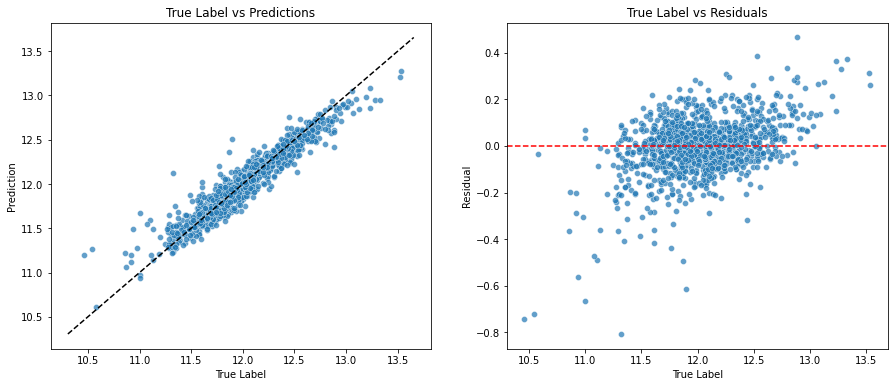

In [18]:
plot_predictions(train_set, y, lasso_oof)

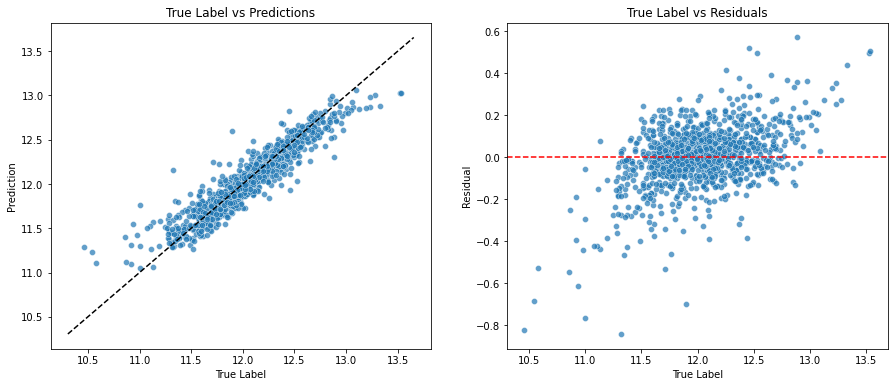

In [19]:
plot_predictions(train_set, y, forest_oof)

At last, I want to see some metrics and the residual plots for the most important features

In [20]:
def evaluate(data, y_true, y_pred, pipe, feat='coef', hue=None, legend=False, savename='test.png'):
    print(f'RMSE: {round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)}')
    print(f'MAE: {round(mean_absolute_error(np.expm1(y_true), np.expm1(y_pred)), 4)}')
    
    plot_predictions(data, y_true, y_pred, hue=hue, legend=legend, savename=savename)
    
    if feat=='coef':
        imp_feat = get_coef(pipe)
    elif feat == 'imp':
        imp_feat = get_feature_importance(pipe)
    else:
        raise AttributeError('The attribute feat can either be coef or imp')
        
    imp_feat['abs'] = abs(imp_feat['score'])
    imp_feat = imp_feat.sort_values(by='abs', ascending=False).head()
    
    if savename.endswith('.png'):
        savename = savename.replace('.png', '_')
    
    for feat in imp_feat.feat:
        feat_savename = savename + feat + '.png'
        try:
            plot_predictions(data, y_true, y_pred, feature=feat,
                         hue=hue, legend=legend, savename=feat_savename)
        except (KeyError, ValueError):
            print(f'{feat} not present in the provided data, probably is generated by a transformation in the pipeline')

RMSE: 0.1217
MAE: 15576.3613
service_area not present in the provided data, probably is generated by a transformation in the pipeline


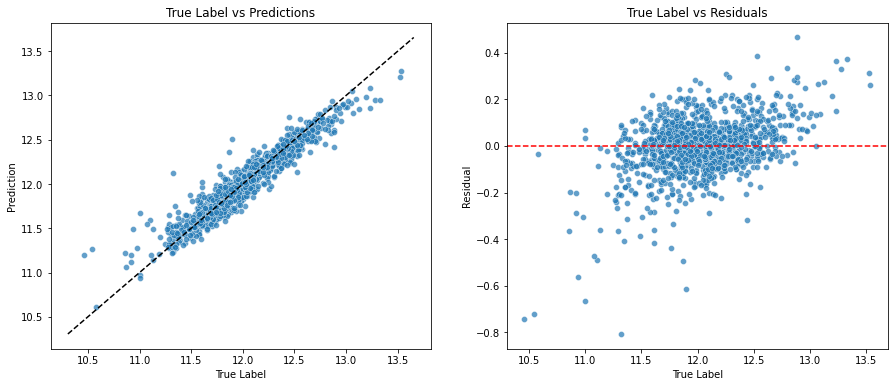

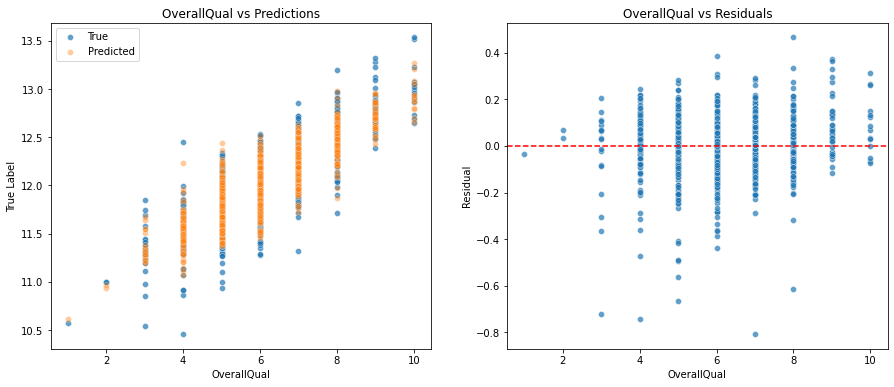

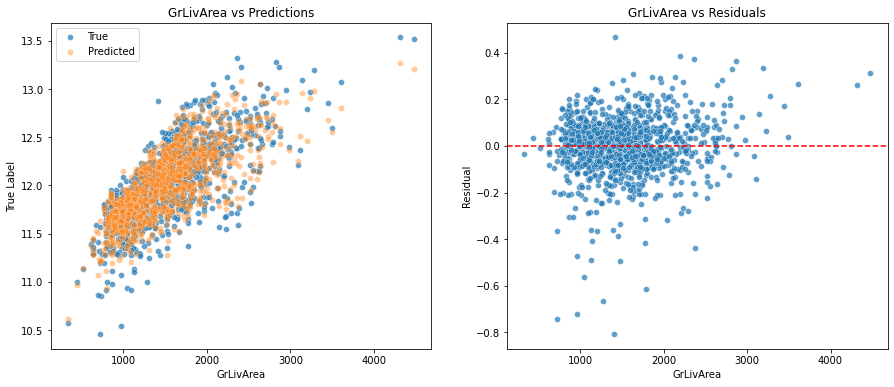

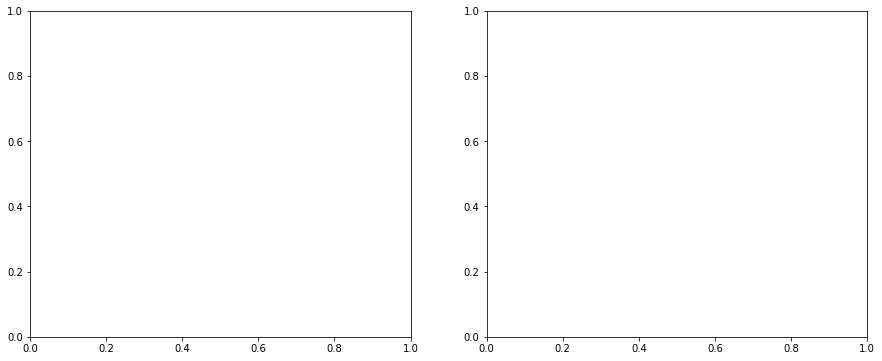

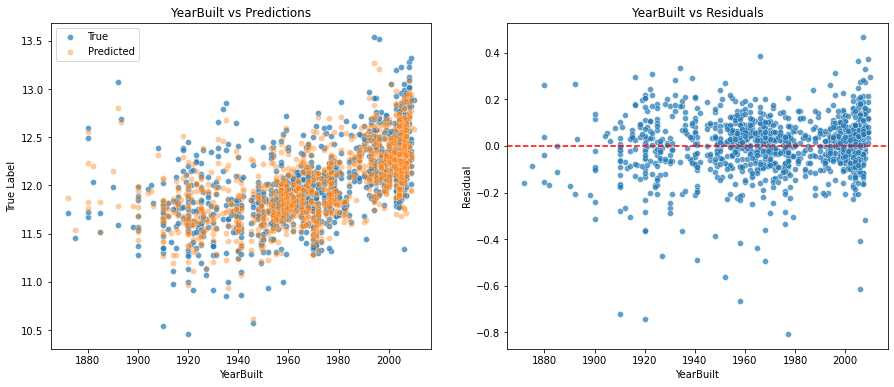

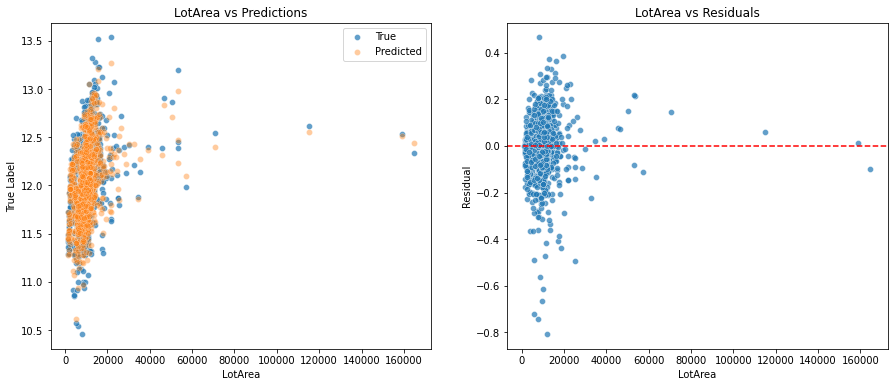

In [22]:
lasso_pipe.fit(train_set, y)
evaluate(train_set, y, lasso_oof, lasso_pipe)

RMSE: 0.1403
MAE: 17763.4293


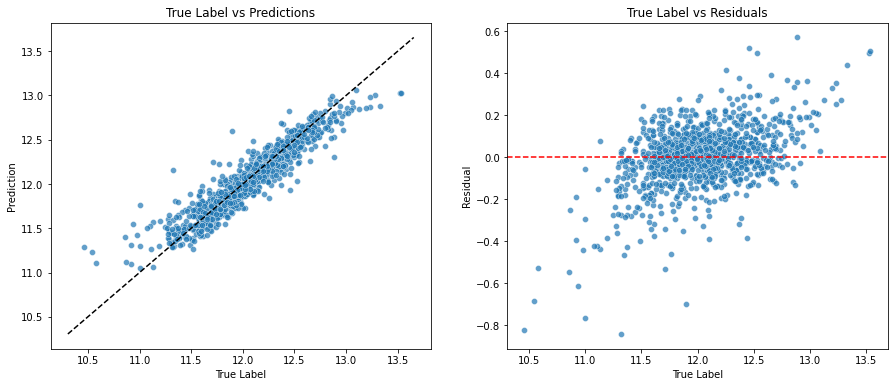

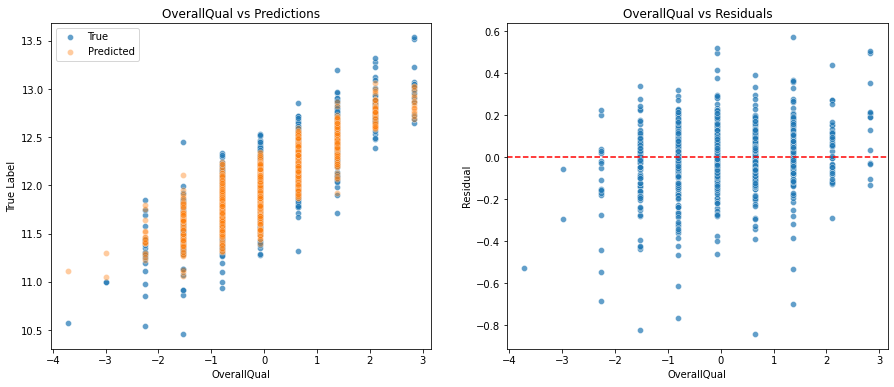

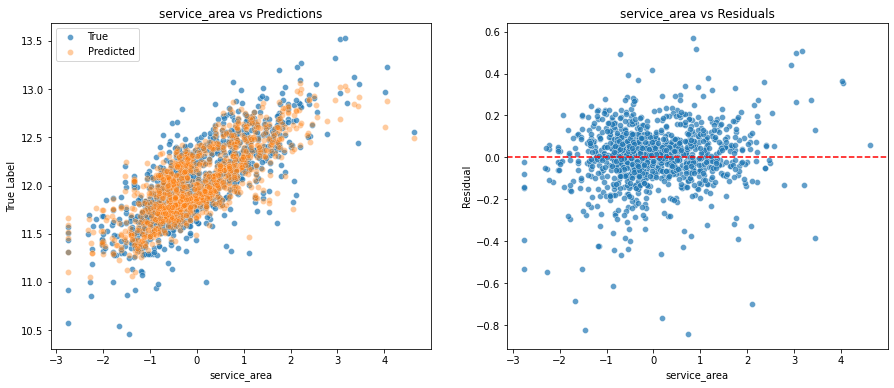

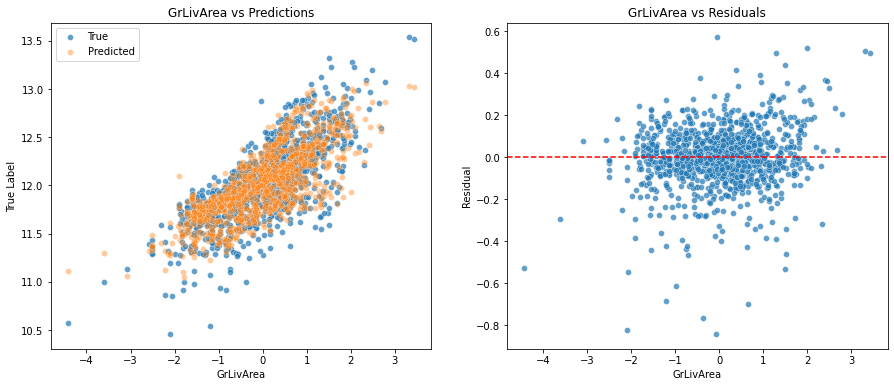

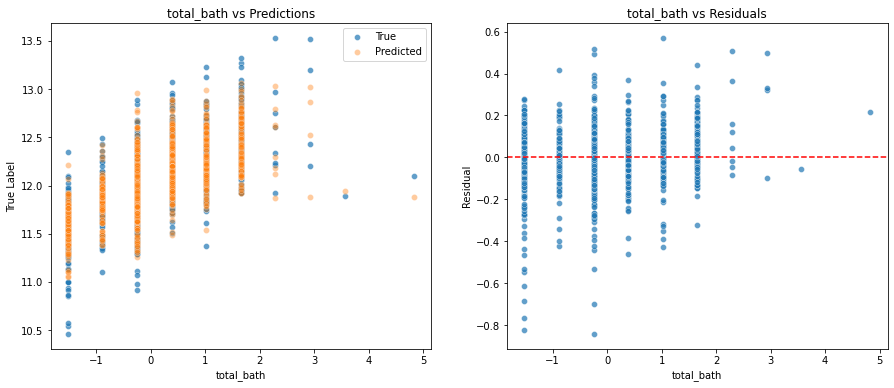

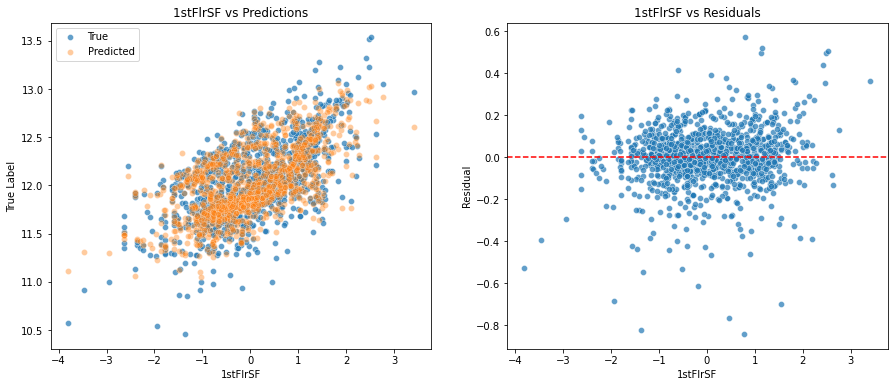

In [24]:
feat_pipe = Pipeline([('gen_cl', general_cleaner()), 
                 ('processing', processing_pipe),
                  ('scl', dfp.df_scaler())])
tmp = train_set.copy()
tmp = feat_pipe.fit_transform(tmp, y)

forest_pipe.fit(train_set, y)

evaluate(tmp, y, forest_oof, forest_pipe, feat='imp')

At last, it might be useful to see the performance on the validation set. The good news is that our functions will do just that.

RMSE: 0.1388
MAE: 16863.3942
service_area not present in the provided data, probably is generated by a transformation in the pipeline


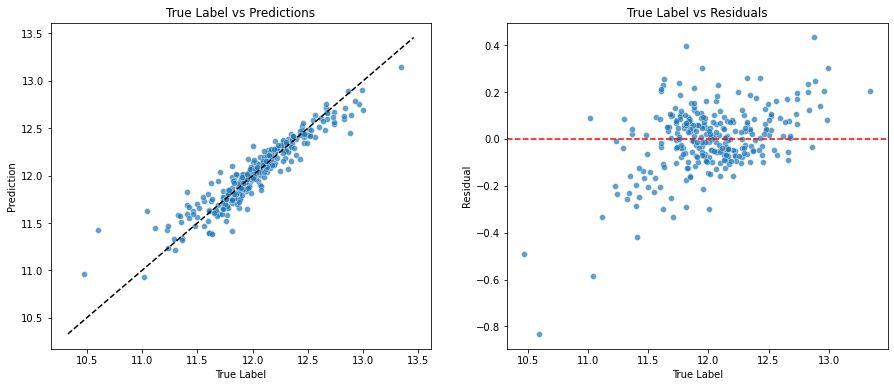

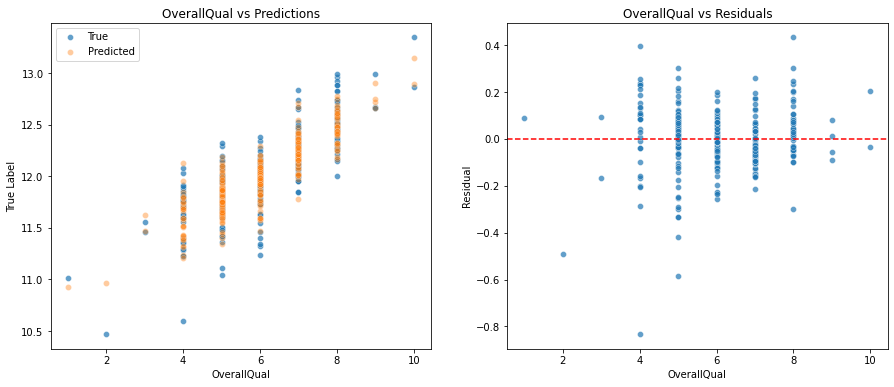

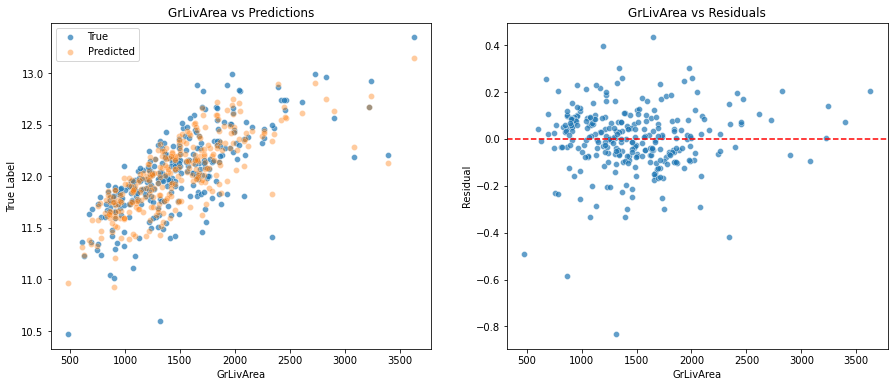

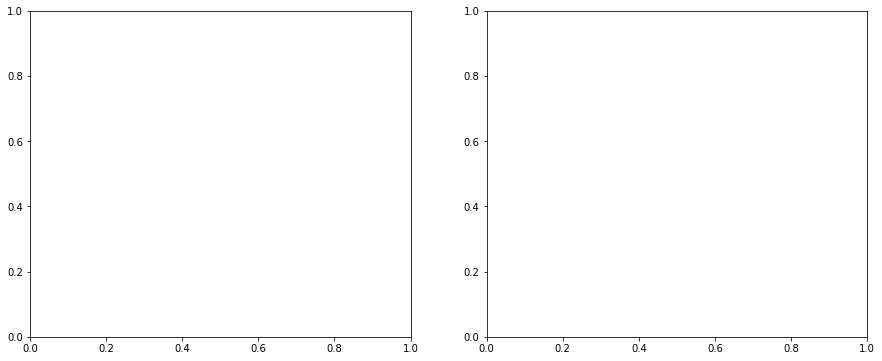

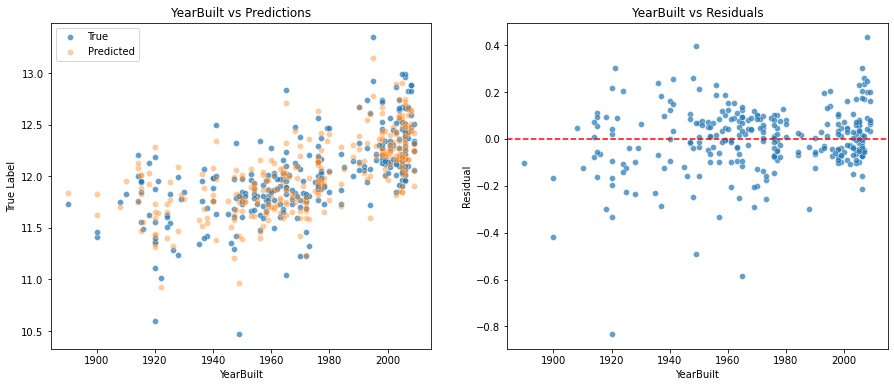

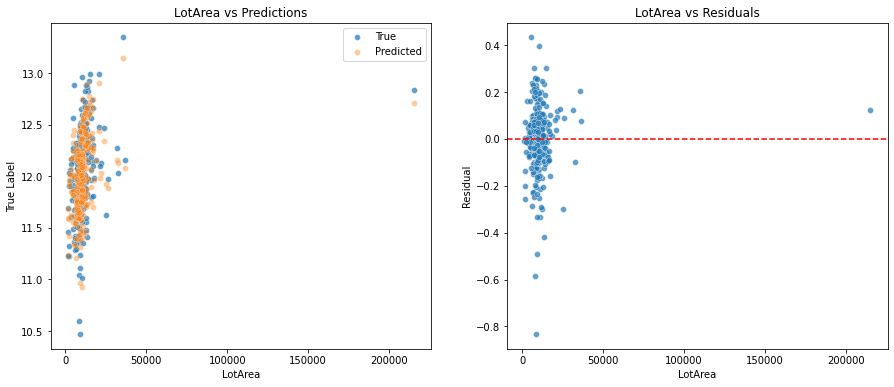

In [25]:
lasso_pred = lasso_pipe.predict(test_set)

evaluate(test_set, y_test, lasso_pred, lasso_pipe)

Staying on our training set, we can use it to tune the hyperparameters via GridSearch

In [26]:
def grid_search(data, target, estimator, param_grid, scoring, cv):
    
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                        cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    
    pd.options.mode.chained_assignment = None
    tmp = data.copy()
    grid = grid.fit(tmp, target)
    pd.options.mode.chained_assignment = 'warn'
    
    result = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_score', 
                                                        ascending=False).reset_index()
    
    del result['params']
    times = [col for col in result.columns if col.endswith('_time')]
    params = [col for col in result.columns if col.startswith('param_')]
    splits = result[[col for col in result.columns if col.startswith('split')]].head()
    splits.columns = [col.split('_test')[0] for col in splits.columns]
    
    splits.T.plot(alpha=0.5, figsize=(12,8))
    plt.savefig('../plots/gridsearch.png')
    plt.close()
    
    result = result[params + ['mean_test_score', 'std_test_score'] + times]
    
    return result, grid.best_params_, grid.best_estimator_

In [27]:
res, bp, best_est = grid_search(train_set, y, lasso_pipe,
                                param_grid={'processing__num_pipe__transf__SF_room': [True, False], 
                        'processing__num_pipe__transf__service': [True, False],
                                            'processing__cat_pipe__recode__mean_weight': [1, 10, 20, 100],
                        'lasso__alpha': [0.1, 0.01, 0.001]},
                                cv=folds, scoring='neg_mean_squared_error')

res.head(10)

,param_lasso__alpha,param_processing__cat_pipe__recode__mean_weight,param_processing__num_pipe__transf__SF_room,param_processing__num_pipe__transf__service,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,0.001,10,False,False,-0.013703,0.001140,0.093360,0.000913,0.055573,0.000362
1,0.001,10,True,False,-0.013706,0.001138,0.099821,0.007438,0.059233,0.003905
2,0.001,20,False,False,-0.013711,0.001137,0.121521,0.018416,0.067287,0.008141
3,0.001,20,True,False,-0.013712,0.001137,0.104850,0.013649,0.057639,0.000954
4,0.001,1,False,False,-0.013728,0.001166,0.102710,0.009229,0.056995,0.002029
5,0.001,1,True,False,-0.013731,0.001163,0.094217,0.000888,0.056329,0.000594
6,0.001,10,False,True,-0.013770,0.001178,0.098802,0.007705,0.057600,0.000906
7,0.001,10,True,True,-0.013771,0.001178,0.101886,0.012196,0.066139,0.016332
8,0.001,100,False,False,-0.013784,0.001193,0.102537,0.009127,0.053971,0.001852
9,0.001,100,True,False,-0.013784,0.001194,0.104489,0.015318,0.058159,0.002309


In [28]:
bp

{'lasso__alpha': 0.001,
 'processing__cat_pipe__recode__mean_weight': 10,
 'processing__num_pipe__transf__SF_room': False,
 'processing__num_pipe__transf__service': False}

In [29]:
best_est.predict(df_test)

array([11.69050909, 11.94614575, 12.08646602, ..., 12.07429853,
       11.65768244, 12.29688138])

Once again, we can use tubesml

In [30]:
res, bp, best_est = tml.grid_search(data=train_set, target=y, estimator=lasso_pipe,
                                param_grid={'processing__num_pipe__transf__SF_room': [True, False], 
                        'processing__num_pipe__transf__service': [True, False],
                                            'processing__cat_pipe__recode__mean_weight': [1, 10, 20, 100],
                        'lasso__alpha': [0.1, 0.01, 0.001]},
                                cv=folds, scoring='neg_mean_squared_error')

print(bp)

print(best_est.predict(df_test)[:10])

res.head()

{'lasso__alpha': 0.001, 'processing__cat_pipe__recode__mean_weight': 10, 'processing__num_pipe__transf__SF_room': False, 'processing__num_pipe__transf__service': False}
[11.69050909 11.94614575 12.08646602 12.17294632 12.19101886 12.05931407
 12.10122029 12.01013823 12.20375441 11.62676012]


,param_lasso__alpha,param_processing__cat_pipe__recode__mean_weight,param_processing__num_pipe__transf__SF_room,param_processing__num_pipe__transf__service,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,0.001,10,False,False,-0.012152,0.000258,-0.013703,0.001140,0.095566,0.003905,0.055521,0.000640
1,0.001,10,True,False,-0.012150,0.000257,-0.013706,0.001138,0.094411,0.000926,0.055356,0.000508
2,0.001,20,False,False,-0.012150,0.000256,-0.013711,0.001137,0.093037,0.000824,0.055032,0.000417
3,0.001,20,True,False,-0.012148,0.000256,-0.013712,0.001137,0.093845,0.001115,0.055826,0.000357
4,0.001,1,False,False,-0.012186,0.000267,-0.013728,0.001166,0.092932,0.000671,0.055154,0.000585


# Learning Curves

A valuable tool to evaluate a model is to use learning curves.

TO be continued